## Zimbabwe GIS

* https://zimgeospatial.github.io/
* https://matthewrocklin.com/blog/work/2017/09/21/accelerating-geopandas-1

In [75]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt

from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.tile_providers import get_provider, Vendors
from bokeh.plotting import figure
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [14]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

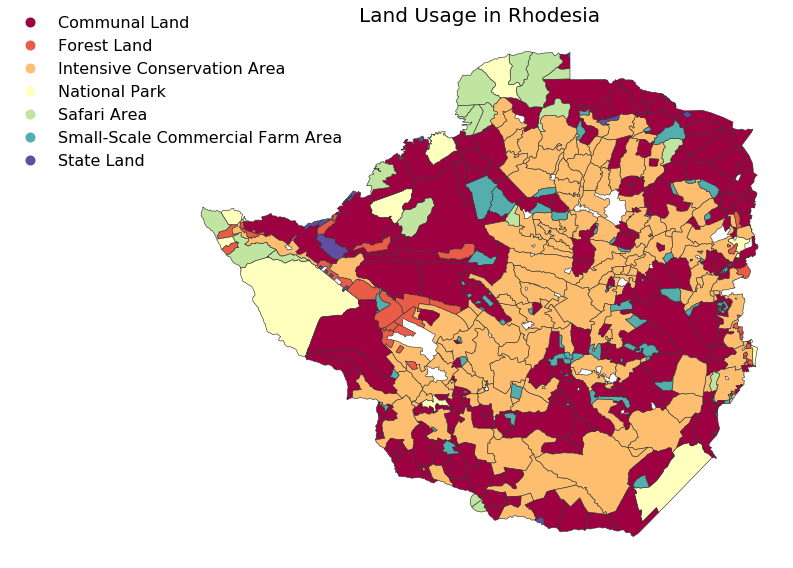

In [145]:
gdf = gpd.read_file('data/historic_land_classes.shp')
gdf = gdf.dropna()
fig, ax = plt.subplots(1, figsize=(14,8))
gdf.plot(column='class', categorical=True,cmap='Spectral',linewidth=.6, edgecolor='0.2', 
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title('Land Usage in Rhodesia',fontsize=20)
plt.tight_layout()
plt.savefig('images/rhodesia_land_classes.png',dpi=300)

In [115]:
def get_merged(shpfile,datafile,key):
    gdf = gpd.read_file(shpfile)
    data = pd.read_csv(datafile)
    gdf = gdf.merge(data,left_on=key,right_on=key,how='left')
    gdf.head()
    return gdf

prov = get_merged('data/admin_level1_provinces.shp','data/province_population.csv','province')
dist = get_merged('data/admin_level2_districts.shp','data/district_population.csv','district')
ward = get_merged('data/admin_level3_wards.shp','data/ward_population.csv' ,'district')

In [114]:
df=pd.read_csv('data/ward_population.csv')
g=df.groupby('district').sum().reset_index()
g.to_csv('data/district_population.csv',index=False)

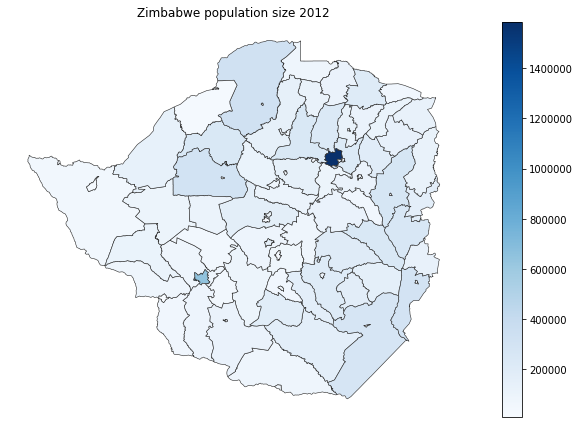

In [147]:
x=dist
fig, ax = plt.subplots(1, figsize=(12,6))
x.plot( column='pop_2012', linewidth=.6, ax=ax, edgecolor='0.2',legend=True, cmap='Blues', )
#labels
#x.apply(lambda x: ax.annotate(s=x.province, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
ax.axis('off')
ax.set_title('Zimbabwe population size 2012')
plt.tight_layout()
plt.savefig('images/zim_district_pop2012.png',dpi=300)

In [126]:
def bokeh_plot_map(geosource, column=None, title='', palette='Blues', label=''):
    """Plot bokeh map from GeoJSONDataSource """
    
    palette = brewer[palette][8]
    palette = palette[::-1]
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette)#, low = 0, high = 100)

    color_bar = ColorBar(label_standoff=8,width = 500, height = 20,
                border_line_color=None,location = (0,0), orientation = 'horizontal')

    hover = HoverTool(
        tooltips=[       
            ("district", "@district"),
            ("population", "@pop_2012")
        ], point_policy='follow_mouse')
    tools = ['wheel_zoom,pan,reset',hover]
    p = figure(title = title, plot_width=600, plot_height=500, toolbar_location = 'right', tools=tools)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #Add patch renderer to figure
    if column != None:
        color = {'field' :column , 'transform': color_mapper}
    else:
        color = 'gray'
    p.patches('xs','ys', source=geosource, line_width=0.8, line_color='black', fill_color=color ) #fill_alpha=1,
    p.toolbar.logo = None
    p.xaxis.visible = False
    p.yaxis.visible = False    
    #Specify figure layout.
    #p.add_layout(color_bar, 'below')
    return p

In [ ]:
geosource = get_geodatasource(dist)
p = bokeh_plot_map(geosource, column='pop_2012')
show(p)

In [ ]:
output_file('plot.html')
show(p)

http://geoviews.org/Geometries.html

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
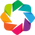

In [42]:
import geoviews as gv
import geoviews.feature as gf
import cartopy
import cartopy.feature as cf

from geoviews import opts
from cartopy import crs as ccrs

gv.extension('matplotlib', 'bokeh')

In [ ]:
gv.Shape.from_shapefile('data/admin_level1_provinces.shp', crs=ccrs.PlateCarree())